In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle

from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import recall_score





In [30]:
cards_df = pd.read_csv('cards_data.csv')
trans_df = pd.read_csv('transactions_data.csv')
users_df = pd.read_csv('users_data.csv')

In [31]:
with open('mcc_codes.json', 'r') as f:
    mcc_data = json.load(f)

with open('train_fraud_labels.json', 'r') as f:
    fraud_labels = json.load(f)

label_data = fraud_labels["target"]

In [32]:
print('User Columns:', users_df.columns)
print('-'*100)
print('Cards Columns:', cards_df.columns)
print('-'*100)
print('Transactions Columns:', trans_df.columns)
print('-'*100)

User Columns: Index(['id', 'current_age', 'retirement_age', 'birth_year', 'birth_month',
       'gender', 'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Cards Columns: Index(['id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires',
       'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Transactions Columns: Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors'],
      dtype='object')
-----------------------------------------------------------------------------------------

In [33]:
print('User Data Types:', users_df.dtypes)
print('-'*100)
print('Cards Data Types:', cards_df.dtypes)
print('-'*100)
print('Transactions Data Types:', trans_df.dtypes)
print('-'*100)

User Data Types: id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object
----------------------------------------------------------------------------------------------------
Cards Data Types: id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object
--------------

In [34]:
print('User Null Values:', users_df.isna().sum())
print('-'*100)
print('Cards Null Values:', cards_df.isna().sum())
print('-'*100)
print('Transactions Null Values:', trans_df.isna().sum())
print('-'*100)

User Null Values: id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64
----------------------------------------------------------------------------------------------------
Cards Null Values: id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64
----------------------------------------------------------------------------------------------------
Transactions Null Values: id                       0
date     

In [35]:
# Combining users, card, and transaction data
merged_df = pd.merge(trans_df, users_df, left_on='client_id', right_on='id', how='left')
#merged_df.drop(columns=['id_x', 'id_y'], inplace=True)
final_df = pd.merge(merged_df, cards_df, left_on='card_id', right_on='id', how='left')

In [36]:
final_df.columns

Index(['id_x', 'date', 'client_id_x', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'id_y', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'gender', 'address', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'id', 'client_id_y', 'card_brand', 'card_type',
       'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued',
       'credit_limit', 'acct_open_date', 'year_pin_last_changed',
       'card_on_dark_web'],
      dtype='object')

In [37]:
final_df.shape

(13305915, 39)

In [40]:
final_df['mcc'] = final_df['mcc'].astype(str)
final_df['mcc_name'] = final_df['mcc'].map(mcc_data)

final_df['id_x'] = final_df['id_x'].astype(str)
final_df['fraud_label'] = final_df['id_x'].map(label_data)

unlabeled_df = final_df[final_df['fraud_label'].isna()]

In [74]:
final_df.head(2)

,id_x,date,client_id_x,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,mcc_name,fraud_label
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,07/2022,306,YES,2,$55,05/2008,2008,No,Miscellaneous Food Stores,No
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,12/2024,438,YES,1,$9100,09/2005,2015,No,Department Stores,No


## Data Cleaning

In [75]:
final_df['errors'].unique()

array([nan, 'Technical Glitch', 'Bad Expiration', 'Bad Card Number',
       'Insufficient Balance', 'Bad PIN', 'Bad CVV', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration',
       'Bad Card Number,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Technical Glitch', 'Bad Expiration,Bad CVV',
       'Bad CVV,Insufficient Balance', 'Bad Card Number,Technical Glitch',
       'Bad Zipcode,Insufficient Balance',
       'Bad Card Number,Bad Expiration,Insufficient Balance',
       'Bad Zipcode,Technical Glitch'], dtype=object)

In [76]:
final_df['errors'].value_counts()

errors
Insufficient Balance                                   130902
Bad PIN                                                 32119
Technical Glitch                                        26271
Bad Card Number                                          7767
Bad Expiration                                           6161
Bad CVV                                                  6106
Bad Zipcode                                              1126
Bad PIN,Insufficient Balance                              293
Insufficient Balance,Technical Glitch                     243
Bad Card Number,Insufficient Balance                       71
Bad PIN,Technical Glitch                                   70
Bad CVV,Insufficient Balance                               57
Bad Expiration,Insufficient Balance                        47
Bad Card Number,Bad CVV                                    38
Bad Card Number,Bad Expiration                             33
Bad Expiration,Bad CVV                                     32
B

In [77]:
print('Null percentage in errors column:', str(round((final_df['errors'].isna().sum()/final_df.shape[0])*100,2))+'%')

Null percentage in errors column: 98.41%


- We have 98.4% of null values in the 'errors' column
- We can utilize existing error messages and create new columns based on assumptions

In [78]:
# Let's create Binary column whether it has error message or not --- "has_error"

final_df['has_error'] = final_df['errors'].notnull().astype(int)


- Let's assume,  there is a less chance of user making a mistake in typing these values: Bad PIN, Bad Card Number, Bad Expiration, Bad CVV, Bad Zipcode
- We can consider these values as 'suspicious_error'

In [79]:
suspicious = ['Bad PIN', 'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode']
final_df['suspicious_error'] = final_df['errors'].apply(lambda x: 1 if isinstance(x, str) and any(err in x for err in suspicious) else 0)


In [80]:
final_df.head(2)

,id_x,date,client_id_x,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,mcc_name,fraud_label,has_error,suspicious_error
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,YES,2,$55,05/2008,2008,No,Miscellaneous Food Stores,No,0,0
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,YES,1,$9100,09/2005,2015,No,Department Stores,No,0,0


In [81]:
final_df["fraud_label"].unique()

array(['No', nan, 'Yes'], dtype=object)

In [82]:
# Removing all rows where "fraud_label" has no value
cleaned_df = final_df[final_df['fraud_label'].notnull()]

In [83]:
cleaned_df.shape

(8914963, 43)

In [8]:
cleaned_df.to_csv('cleaned_data.csv')

In [2]:
cleaned_df = pd.read_csv('cleaned_data.csv')

In [4]:
cleaned_df.head()

,Unnamed: 0,id_x,date,client_id_x,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,...,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,mcc_name,fraud_label,has_error,suspicious_error
0,0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,...,YES,2,$55,05/2008,2008,No,Miscellaneous Food Stores,No,0,0
1,1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,...,YES,1,$9100,09/2005,2015,No,Department Stores,No,0,0
2,2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,...,YES,1,$14802,01/2006,2008,No,Money Transfer,No,0,0
3,4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,...,YES,1,$19113,07/2009,2014,No,Drinking Places (Alcoholic Beverages),No,0,0
4,5,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,...,YES,1,$89,01/2008,2015,No,Book Stores,No,0,0


In [5]:
cleaned_df.shape

(8914963, 44)

In [3]:
cleaned_df.columns

Index(['Unnamed: 0', 'id_x', 'date', 'client_id_x', 'card_id', 'amount',
       'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip',
       'mcc', 'errors', 'id_y', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'gender', 'address', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'id', 'client_id_y', 'card_brand', 'card_type',
       'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued',
       'credit_limit', 'acct_open_date', 'year_pin_last_changed',
       'card_on_dark_web', 'mcc_name', 'fraud_label', 'has_error',
       'suspicious_error'],
      dtype='object')

In [6]:
cleaned_df['card_on_dark_web'].value_counts()

card_on_dark_web
No    8914963
Name: count, dtype: int64

- All the values in card_on_dark_web is "No", since it's biased, we remove the column

In [7]:
# Removing the columns that might not be useful
cleaned_df.drop(['errors', 'zip', 'Unnamed: 0', 'id_x', 'id_y', 'birth_month', 'client_id_y', 'card_on_dark_web'], axis=1, inplace=True)

In [9]:
# Using the exisiting merchant city and merchant_state, replacing the null values in merchant state column
city_state_map = cleaned_df.dropna(subset=['merchant_state']).groupby('merchant_city')['merchant_state'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown').to_dict()

cleaned_df['merchant_state'] = cleaned_df.apply(
    lambda row: city_state_map.get(row['merchant_state'], 'Unknown') if pd.isnull(row['merchant_state']) else row['merchant_state'],
    axis=1
)

cleaned_df['merchant_state'].value_counts()

merchant_state
Unknown       1047865
CA             956356
TX             677139
NY             574521
FL             469600
               ...   
Gabon               2
Suriname            2
Tonga               1
Ethiopia            1
Azerbaijan          1
Name: count, Length: 200, dtype: int64

- We can observe there are still unknown merchant state values, we will have "unknown" as one separate category. 
- These "unknown" values can be due to international transactions. 

In [10]:
cleaned_df.isna().sum()

date                     0
client_id_x              0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
mcc                      0
current_age              0
retirement_age           0
birth_year               0
gender                   0
address                  0
latitude                 0
longitude                0
per_capita_income        0
yearly_income            0
total_debt               0
credit_score             0
num_credit_cards         0
id                       0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
mcc_name                 0
fraud_label              0
has_error                0
suspicious_error         0
dtype: int64

In [11]:
# Replacing "$" and ',' with empty space
def clean_currency(val):
    if isinstance(val, str):
        return val.replace("$", "").replace(",", "")
    return val


numeric_cols = ['amount', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_limit']
for cols in numeric_cols:
    cleaned_df[cols] = cleaned_df[cols].apply(clean_currency).astype(float)

In [12]:
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'], errors='coerce')
cleaned_df['expires'] = pd.to_datetime(cleaned_df['expires'], format="%m/%Y").dt.to_period('M')
cleaned_df['acct_open_date'] = pd.to_datetime(cleaned_df['acct_open_date'], format="%m/%Y").dt.to_period('M')

In [14]:
# Replacing "Yes" & "No" with 1 & 0 respectively.
cleaned_df['has_chip'] = cleaned_df['has_chip'].map({"YES": 1, "NO": 0})
cleaned_df['fraud_label'] = cleaned_df['fraud_label'].map({'Yes': 1, 'No': 0})

# Creating New Features

In [ ]:
# Age of the account
cleaned_df['account_age_months'] = (cleaned_df['date'].dt.to_period("M") - cleaned_df['acct_open_date']).apply(lambda x: x.n) 

# he number of months left until the card expires from the transaction date
cleaned_df['months_until_expiry'] = (cleaned_df['expires'] - cleaned_df['date'].dt.to_period('M')).apply(lambda x: x.n)

# number of years since the pin changed
cleaned_df['years_since_pin_changed'] = cleaned_df['year_pin_last_changed'] - cleaned_df['acct_open_date'].dt.year

In [18]:
cleaned_df.head(2)

,date,client_id_x,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,mcc,current_age,...,credit_limit,acct_open_date,year_pin_last_changed,mcc_name,fraud_label,has_error,suspicious_error,account_age_months,months_until_expiry,years_since_pin_changed
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,5499,30,...,55.0,2008-05,2008,Miscellaneous Food Stores,0,0,0,20,150,0
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,5311,48,...,9100.0,2005-09,2015,Department Stores,0,0,0,52,179,10


In [20]:
cleaned_df.to_csv('cleaned_data.csv')

## Exploratory Data Analysis

In [21]:
final_df = pd.read_csv('cleaned_data.csv')

Distribution Analysis for Numerical Columns:

Descriptive Statistics for amount:
count    8.914963e+06
mean     4.294939e+01
std      8.152652e+01
min     -5.000000e+02
25%      8.930000e+00
50%      2.899000e+01
75%      6.368000e+01
max      6.613440e+03
Name: amount, dtype: float64
Skewness = 5.06, Kurtosis = 100.46


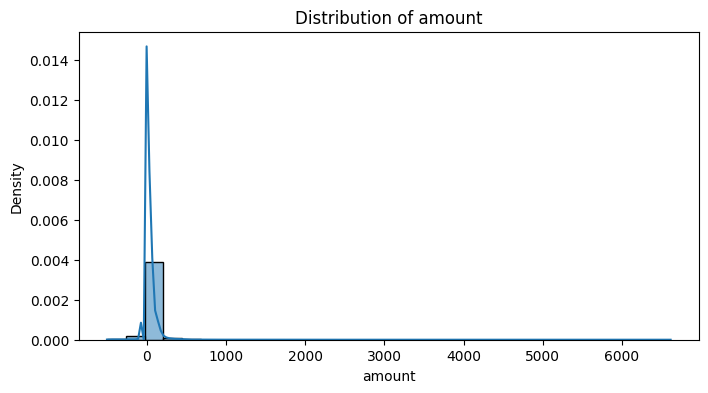


Descriptive Statistics for current_age:
count    8.914963e+06
mean     5.402147e+01
std      1.572477e+01
min      2.300000e+01
25%      4.200000e+01
50%      5.200000e+01
75%      6.300000e+01
max      1.010000e+02
Name: current_age, dtype: float64
Skewness = 0.55, Kurtosis = -0.28


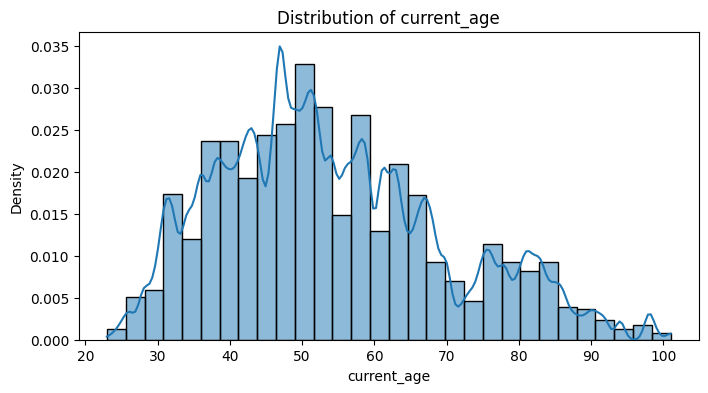


Descriptive Statistics for retirement_age:
count    8.914963e+06
mean     6.648777e+01
std      3.587085e+00
min      5.300000e+01
25%      6.500000e+01
50%      6.600000e+01
75%      6.800000e+01
max      7.900000e+01
Name: retirement_age, dtype: float64
Skewness = -0.32, Kurtosis = 1.39


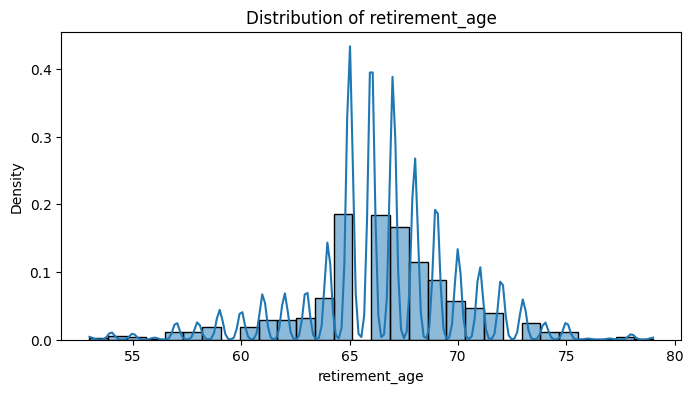


Descriptive Statistics for birth_year:
count    8.914963e+06
mean     1.965160e+03
std      1.571386e+01
min      1.918000e+03
25%      1.956000e+03
50%      1.968000e+03
75%      1.977000e+03
max      1.996000e+03
Name: birth_year, dtype: float64
Skewness = -0.55, Kurtosis = -0.27


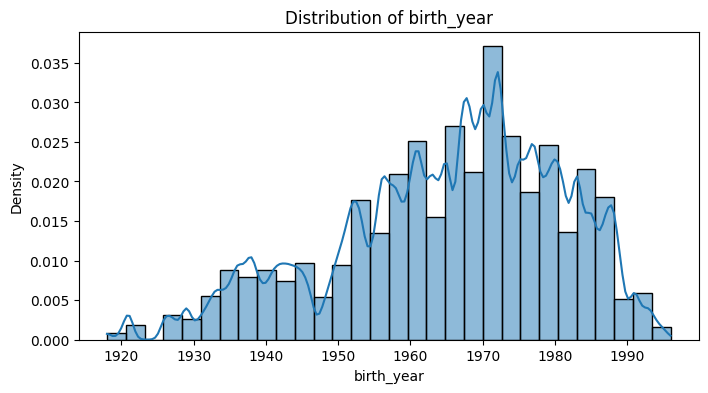

birth_month not found in DataFrame

Descriptive Statistics for latitude:
count    8.914963e+06
mean     3.737615e+01
std      5.091677e+00
min      2.130000e+01
25%      3.389000e+01
50%      3.835000e+01
75%      4.112000e+01
max      4.853000e+01
Name: latitude, dtype: float64
Skewness = -0.40, Kurtosis = -0.27


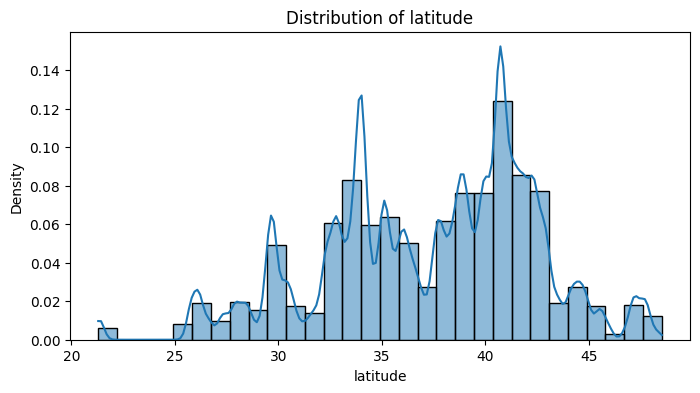


Descriptive Statistics for longitude:
count    8.914963e+06
mean    -9.156999e+01
std      1.626130e+01
min     -1.581800e+02
25%     -9.737000e+01
50%     -8.647000e+01
75%     -8.012000e+01
max     -6.867000e+01
Name: longitude, dtype: float64
Skewness = -1.03, Kurtosis = 0.50


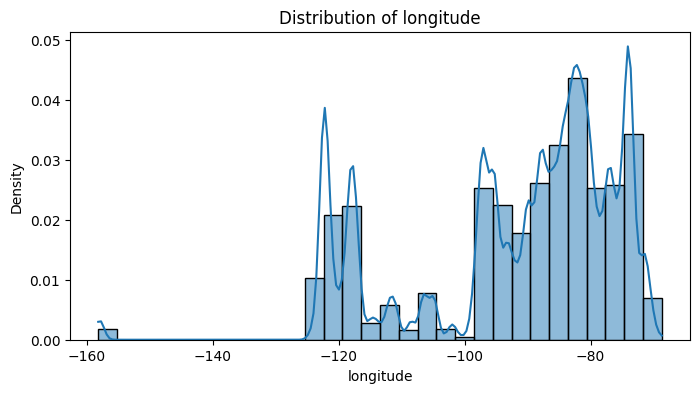


Descriptive Statistics for per_capita_income:
count    8.914963e+06
mean     2.398357e+04
std      1.197540e+04
min      0.000000e+00
25%      1.711300e+04
50%      2.115600e+04
75%      2.730800e+04
max      1.631450e+05
Name: per_capita_income, dtype: float64
Skewness = 3.72, Kurtosis = 26.24


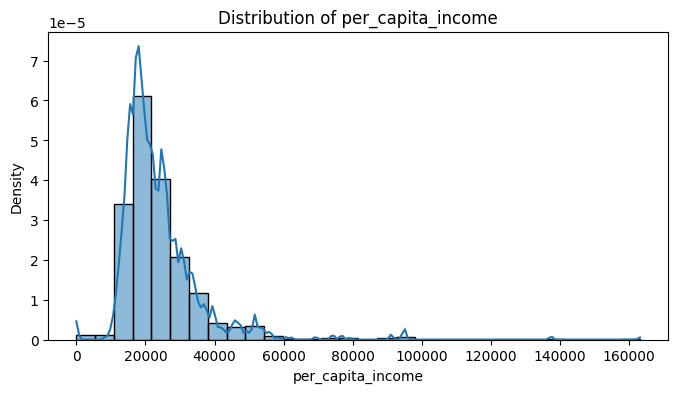


Descriptive Statistics for yearly_income:
count    8.914963e+06
mean     4.669135e+04
std      2.445588e+04
min      1.000000e+00
25%      3.281700e+04
50%      4.109100e+04
75%      5.401300e+04
max      2.801990e+05
Name: yearly_income, dtype: float64
Skewness = 3.11, Kurtosis = 18.10


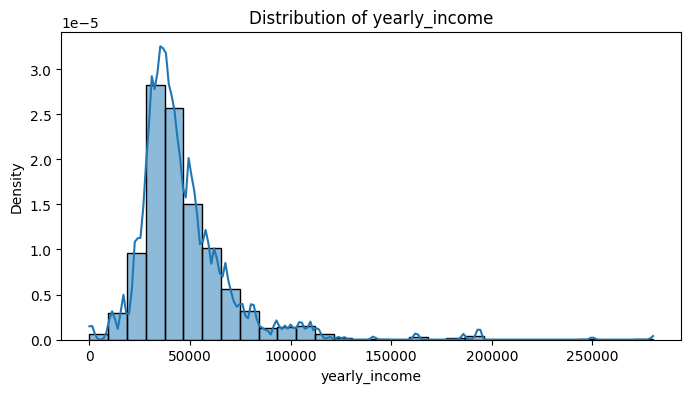


Descriptive Statistics for total_debt:
count    8.914963e+06
mean     5.802153e+04
std      5.209717e+04
min      0.000000e+00
25%      1.643700e+04
50%      5.167900e+04
75%      8.516000e+04
max      4.618540e+05
Name: total_debt, dtype: float64
Skewness = 1.75, Kurtosis = 7.07


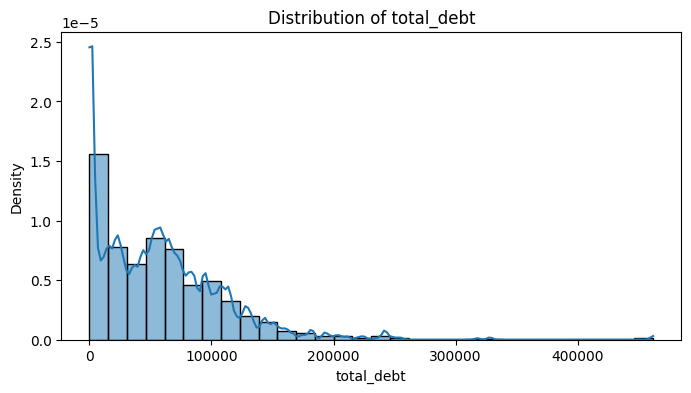


Descriptive Statistics for credit_score:
count    8.914963e+06
mean     7.139262e+02
std      6.581489e+01
min      4.880000e+02
25%      6.840000e+02
50%      7.160000e+02
75%      7.560000e+02
max      8.500000e+02
Name: credit_score, dtype: float64
Skewness = -0.60, Kurtosis = 0.82


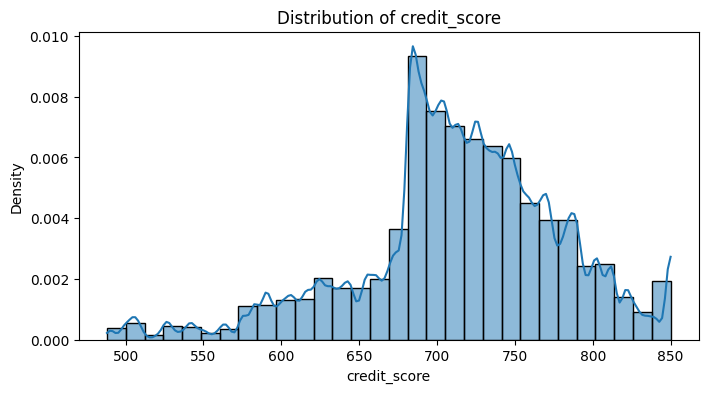


Descriptive Statistics for num_credit_cards:
count    8.914963e+06
mean     3.841198e+00
std      1.567701e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      9.000000e+00
Name: num_credit_cards, dtype: float64
Skewness = 0.31, Kurtosis = -0.08


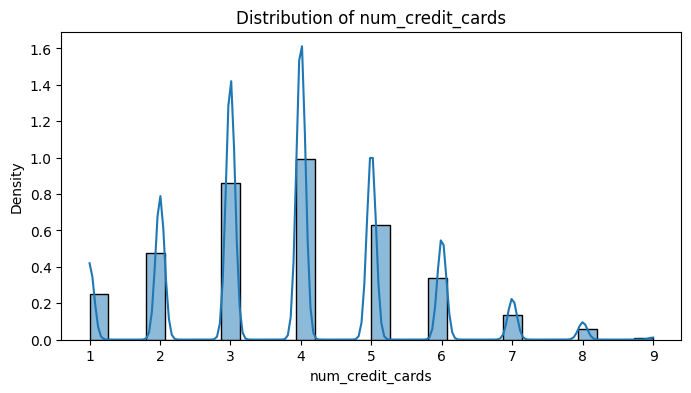


Descriptive Statistics for num_cards_issued:
count    8.914963e+06
mean     1.522064e+00
std      5.151711e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      3.000000e+00
Name: num_cards_issued, dtype: float64
Skewness = 0.09, Kurtosis = -1.57


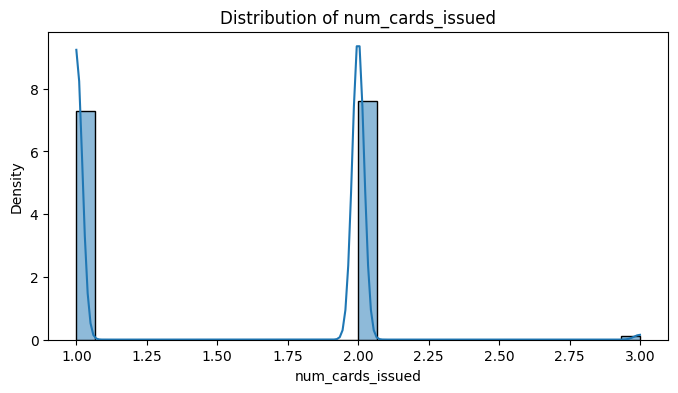


Descriptive Statistics for credit_limit:
count    8.914963e+06
mean     1.554959e+04
std      1.218199e+04
min      0.000000e+00
25%      8.100000e+03
50%      1.345500e+04
75%      2.083900e+04
max      1.413910e+05
Name: credit_limit, dtype: float64
Skewness = 2.43, Kurtosis = 14.55


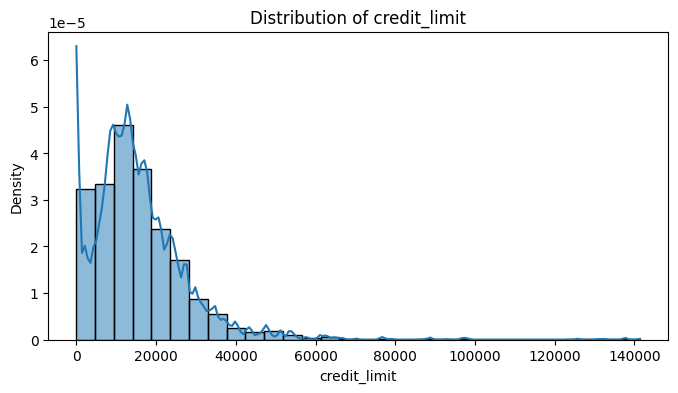


Descriptive Statistics for year_pin_last_changed:
count    8.914963e+06
mean     2.011340e+03
std      2.894518e+00
min      2.002000e+03
25%      2.010000e+03
50%      2.011000e+03
75%      2.013000e+03
max      2.020000e+03
Name: year_pin_last_changed, dtype: float64
Skewness = 0.36, Kurtosis = 0.29


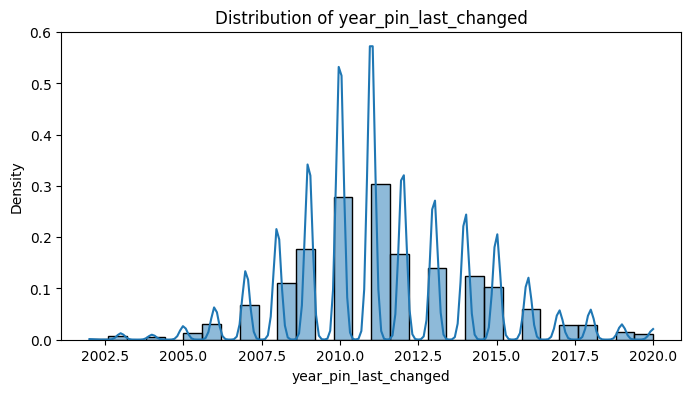


Descriptive Statistics for account_age_months:
count    8.914963e+06
mean     8.590273e+01
std      5.392900e+01
min     -1.800000e+01
25%      4.300000e+01
50%      8.000000e+01
75%      1.200000e+02
max      3.450000e+02
Name: account_age_months, dtype: float64
Skewness = 0.62, Kurtosis = 0.09


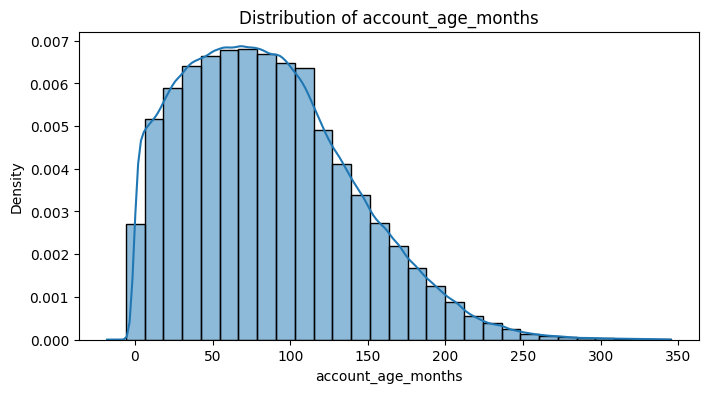


Descriptive Statistics for months_until_expiry:
count    8.914963e+06
mean     8.269997e+01
std      4.005058e+01
min     -1.000000e+00
25%      5.200000e+01
50%      8.200000e+01
75%      1.130000e+02
max      1.790000e+02
Name: months_until_expiry, dtype: float64
Skewness = 0.08, Kurtosis = -0.79


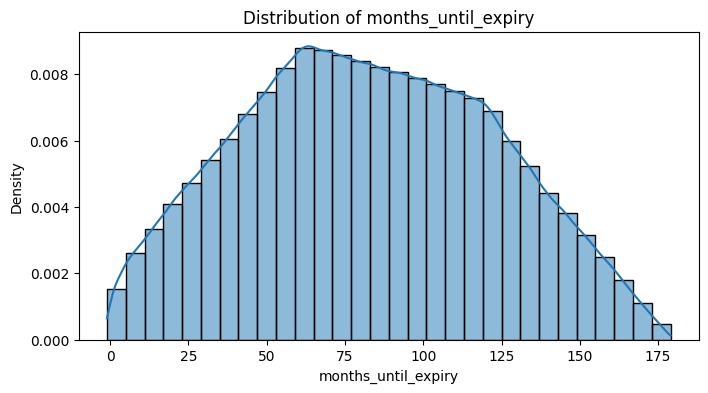


Descriptive Statistics for years_since_pin_changed:
count    8.914963e+06
mean     3.981091e+00
std      4.244063e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      7.000000e+00
max      2.500000e+01
Name: years_since_pin_changed, dtype: float64
Skewness = 1.07, Kurtosis = 0.61


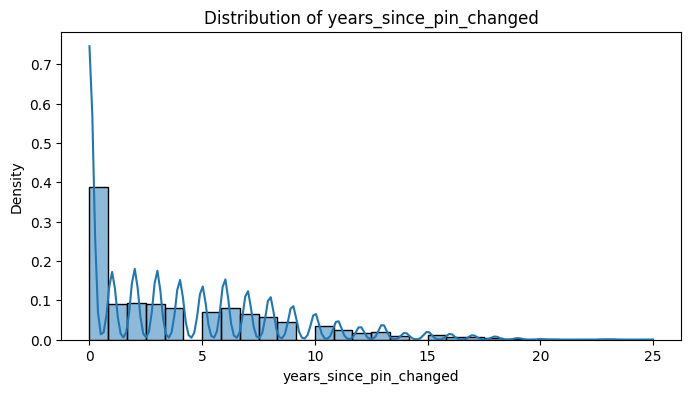

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Define numerical columns based on your dtype list
numerical_cols = [
    'amount', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 
    'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
    'credit_score', 'num_credit_cards', 'num_cards_issued', 'credit_limit',
    'year_pin_last_changed', 'account_age_months', 'months_until_expiry', 
    'years_since_pin_changed', 
    
]

# --- Numerical Columns Distribution ---
print("Distribution Analysis for Numerical Columns:")
for col in numerical_cols:
    if col in final_df.columns:
        # Descriptive statistics
        print(f"\nDescriptive Statistics for {col}:")
        print(final_df[col].describe())
        
        # Skewness and Kurtosis
        skewness = final_df[col].skew()
        kurtosis = final_df[col].kurtosis()
        print(f"Skewness = {skewness:.2f}, Kurtosis = {kurtosis:.2f}")
        
        # Histogram with KDE
        plt.figure(figsize=(8, 4))
        sns.histplot(final_df[col].dropna(), bins=30, kde=True, stat='density')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.show()
    else:
        print(f"{col} not found in DataFrame")

- We can observe certain features are right, left skewed and some are almost normally distributed.

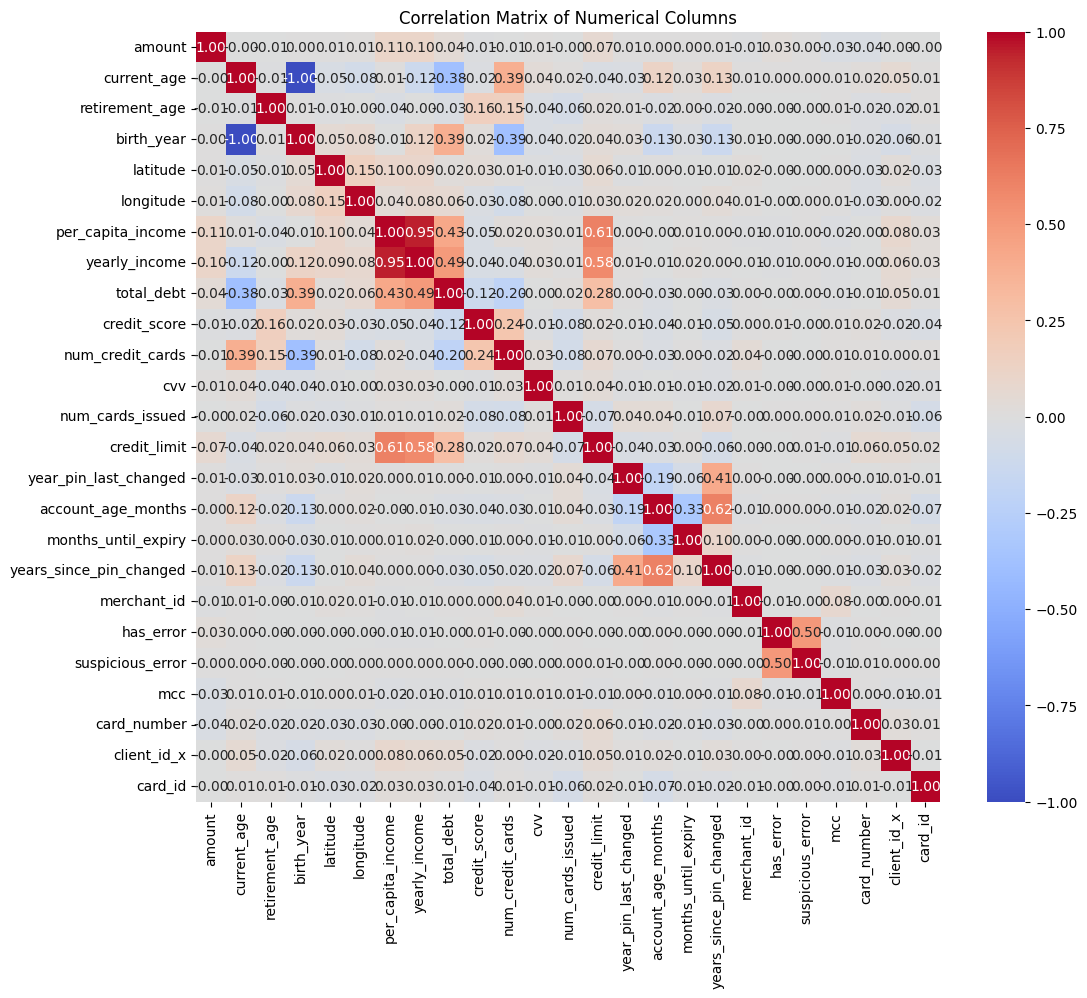

In [25]:
# Let's check for correlation between features
numerical_cols = [
    'amount', 'current_age', 'retirement_age', 'birth_year', 
    'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
    'credit_score', 'num_credit_cards', 'cvv', 'num_cards_issued', 'credit_limit',
    'year_pin_last_changed', 'account_age_months', 'months_until_expiry', 
    'years_since_pin_changed', 'merchant_id', 'has_error', 'suspicious_error', 
    'mcc', 'card_number', 'client_id_x', 'card_id'
]

corr_matrix = final_df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [26]:
# Let's remove one of the two columns which is highly correlated
threshold = 0.8
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print(high_corr_pairs)

[('current_age', 'birth_year', -0.9996992108311735), ('per_capita_income', 'yearly_income', 0.9493728476684737)]


- The pairs (current_age and birth_year), (per_capita_income and yearly_income) are highly correlated

In [27]:
# Let's confirm the correlation of these features each other by comparing with 'fraud label'
for col in ['per_capita_income', 'yearly_income']:
    corr = final_df[[col, 'fraud_label']].corr().iloc[0, 1]
    print(f"{col} correlation with fraud_label: {corr:.3f}")

print("-"*50)

for col in ["current_age", "birth_year"]:
    corr = final_df[[col, "fraud_label"]].corr().iloc[0, 1]
    print(f"{col} correlation with fraud_label: {corr:.3f}")

per_capita_income correlation with fraud_label: -0.003
yearly_income correlation with fraud_label: -0.004
--------------------------------------------------
current_age correlation with fraud_label: 0.004
birth_year correlation with fraud_label: -0.004


- The magnitude of these features are similar to each other, so we remove one of them in each pair

In [28]:
# Removing 'birth_year, per_capita_income' features 
final_df.drop(columns=["birth_year", "per_capita_income"], axis=1, inplace=True) 


In [30]:
final_df.to_csv("new_base.csv")

In [2]:
final_df = pd.read_csv("new_base.csv")

In [3]:
final_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'client_id_x', 'card_id',
       'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state',
       'mcc', 'current_age', 'retirement_age', 'gender', 'address', 'latitude',
       'longitude', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'id', 'card_brand', 'card_type', 'card_number',
       'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit',
       'acct_open_date', 'year_pin_last_changed', 'mcc_name', 'fraud_label',
       'has_error', 'suspicious_error', 'account_age_months',
       'months_until_expiry', 'years_since_pin_changed'],
      dtype='object')

In [4]:
# Get all categorical columns
categorical_cols = final_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Print categorical columns
print(categorical_cols)

['date', 'use_chip', 'merchant_city', 'merchant_state', 'gender', 'address', 'card_brand', 'card_type', 'expires', 'acct_open_date', 'mcc_name']


In [5]:
final_df["fraud_label"].value_counts()

fraud_label
0    8901631
1      13332
Name: count, dtype: int64

### Categorical Columns

#### Chi - Square Test

In [6]:

# Note: 'date', 'expires', 'acct_open_date' will be dropped when training to avoid redundancy, since we used those columns to create new features
categorical_cols = [
    'use_chip', 'merchant_city', 'merchant_state', 'gender', 'address', 
    'card_brand', 'card_type', 'mcc_name'
]

# chi-square test with expected frequency check
def chi_square_test(col):
    if col in final_df.columns and 'fraud_label' in final_df.columns:
        contingency_table = pd.crosstab(final_df[col], final_df['fraud_label'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        # Check if any expected frequency is < 5
        min_expected = expected.min()
        if min_expected < 5:
            print(f"Warning: {col} has min expected frequency {min_expected:.2f} < 5, chi-square may be unreliable")
        return p, contingency_table
    return None, None

p_values = {}
for col in categorical_cols:
    p, contingency = chi_square_test(col)
    if p is not None:
        p_values[col] = p
        print(f"{col}: p-value = {p:.4f}")
    else:
        print(f"{col} or fraud_label not in DataFrame")

# Recommend columns to keep (p < 0.05 or practical significance)
cols_to_keep = [col for col in p_values if p_values[col] < 0.05]
cols_to_drop = [col for col in p_values if p_values[col] >= 0.05]
print("\nRecommended categorical columns to keep (p < 0.05):", cols_to_keep)
print("Recommended categorical columns to consider dropping (p >= 0.05):", cols_to_drop)

use_chip: p-value = 0.0000
merchant_city: p-value = 0.0000
merchant_state: p-value = 0.0000
gender: p-value = 0.0086
address: p-value = 0.0000
card_brand: p-value = 0.0000
card_type: p-value = 0.0000
mcc_name: p-value = 0.0000

Recommended categorical columns to keep (p < 0.05): ['use_chip', 'merchant_city', 'merchant_state', 'gender', 'address', 'card_brand', 'card_type', 'mcc_name']
Recommended categorical columns to consider dropping (p >= 0.05): []


##### Mutual Information Test

In [7]:

def mutual_info_test(col):

    X = pd.factorize(final_df[col])[0].reshape(-1, 1)
    y = final_df['fraud_label']
    mi = mutual_info_classif(X, y, discrete_features=True, random_state=42 )[0]
    print(f"{col}: Mutual Information = {mi:.4f}")
    return mi
    

for col in categorical_cols:
    mutual_info_test(col)

use_chip: Mutual Information = 0.0013
merchant_city: Mutual Information = 0.0043
merchant_state: Mutual Information = 0.0039
gender: Mutual Information = 0.0000
address: Mutual Information = 0.0006
card_brand: Mutual Information = 0.0000
card_type: Mutual Information = 0.0000
mcc_name: Mutual Information = 0.0019


##### Visualizing Fraud Label vs Categorical columns

use_chip: 3 unique values


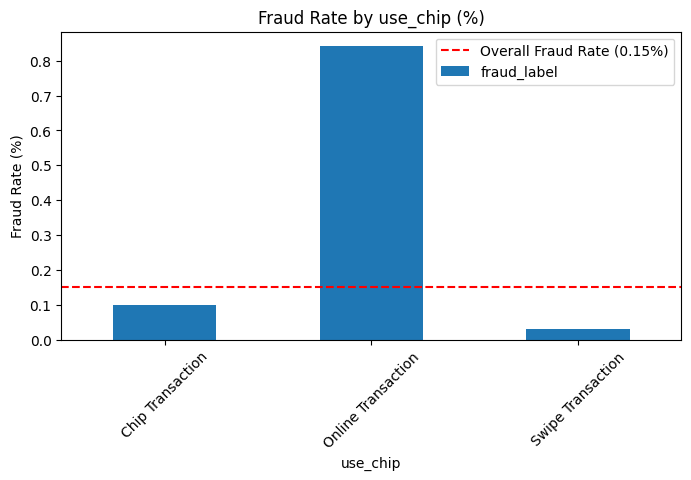

merchant_city: 12173 unique values


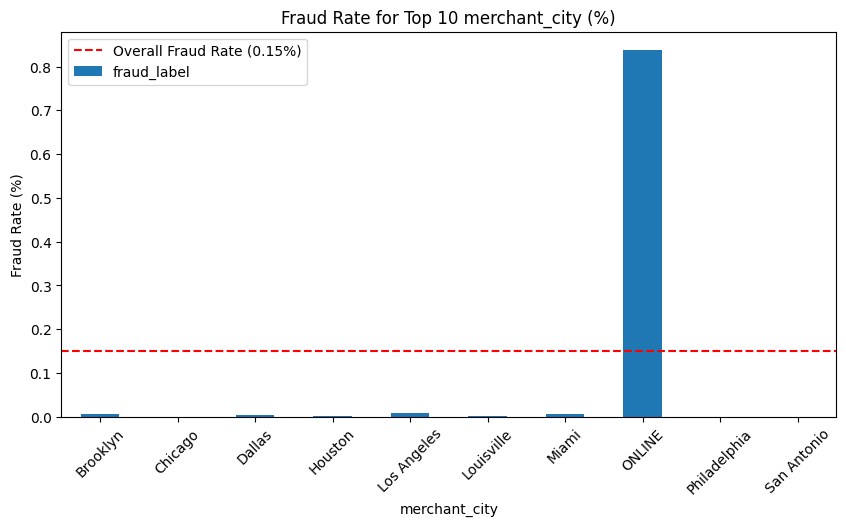

merchant_state: 200 unique values


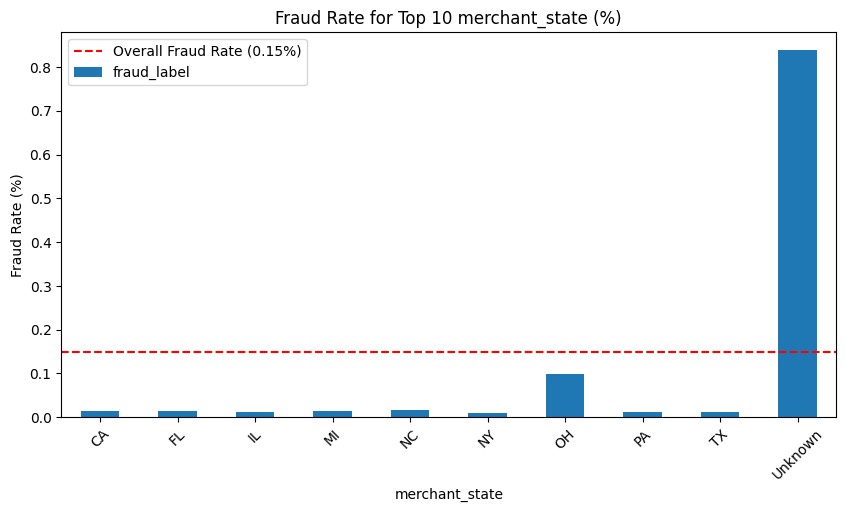

gender: 2 unique values


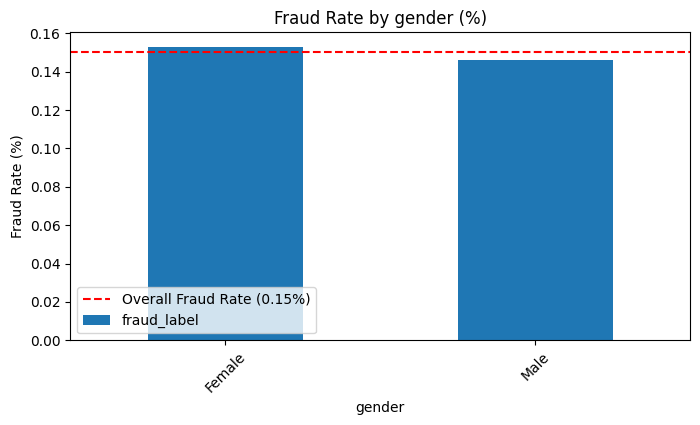

address: 1219 unique values


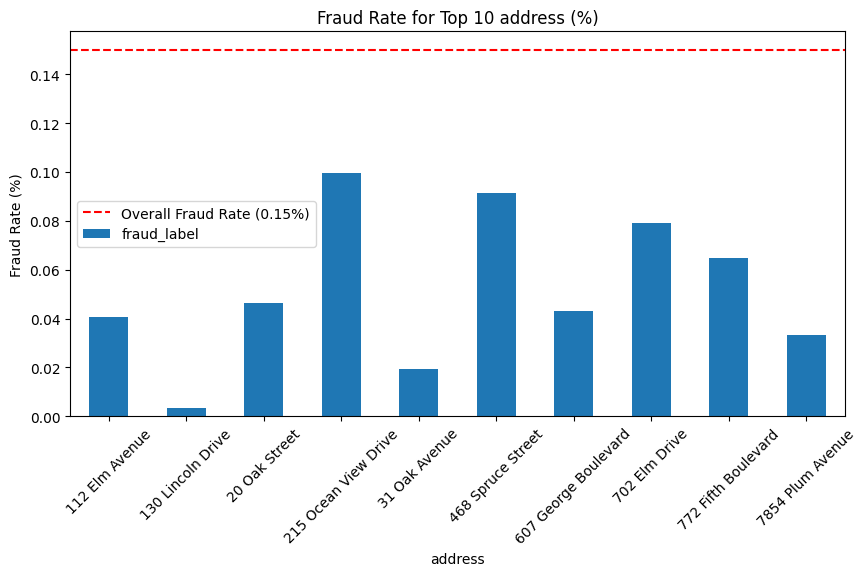

card_brand: 4 unique values


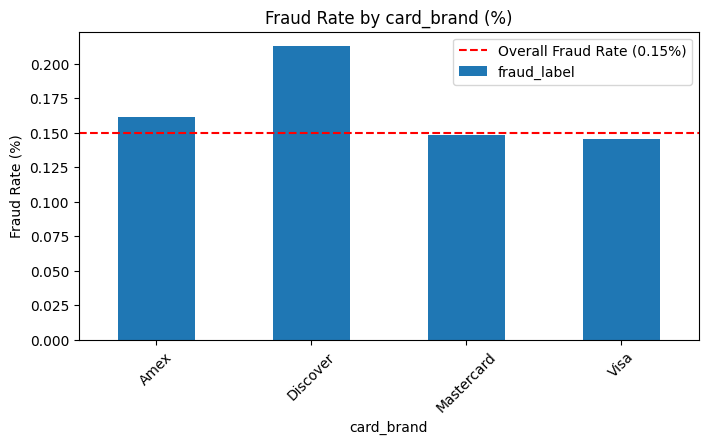

card_type: 3 unique values


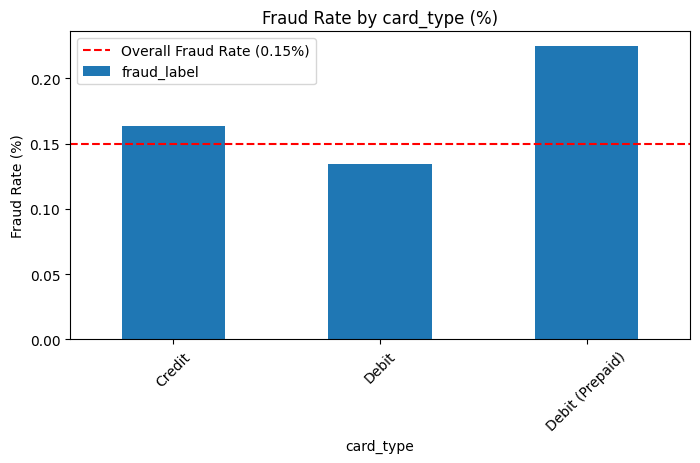

mcc_name: 108 unique values


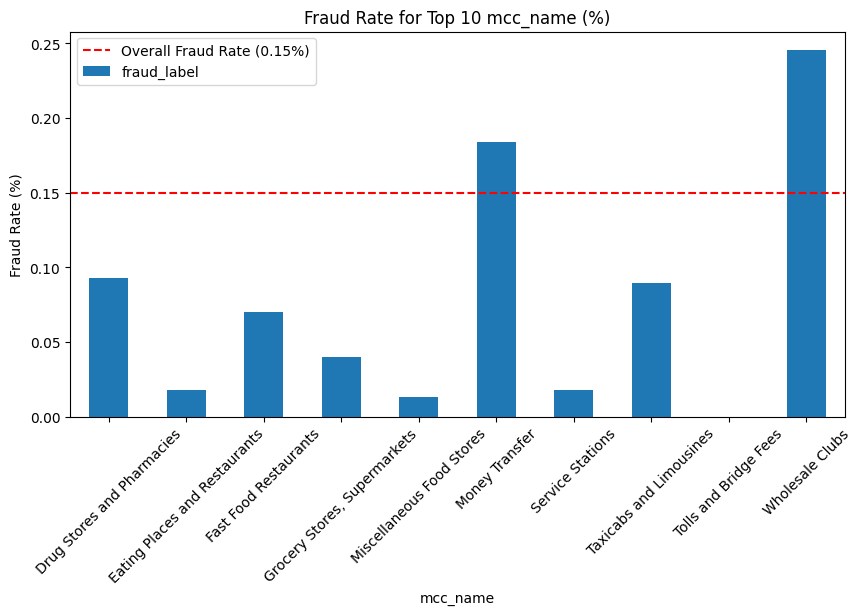

In [ ]:

# Visualize fraud rates
for col in categorical_cols:
    n_unique = final_df[col].nunique()
    print(f"{col}: {n_unique} unique values")
    
    if n_unique <= 20:  # Low-cardinality
        fraud_rate = final_df.groupby(col)['fraud_label'].mean() * 100 
        plt.figure(figsize=(8, 4))
        fraud_rate.plot(kind='bar')
        plt.title(f'Fraud Rate by {col} (%)')
        plt.xlabel(col)
        plt.ylabel('Fraud Rate (%)')
        plt.axhline(y=0.15, color='r', linestyle='--', label='Overall Fraud Rate (0.15%)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()
    else:  # High-cardinality
        top_10 = final_df[col].value_counts().head(10).index
        fraud_rate_top10 = final_df[final_df[col].isin(top_10)].groupby(col)['fraud_label'].mean() * 100
        plt.figure(figsize=(10, 5))
        fraud_rate_top10.plot(kind='bar')
        plt.title(f'Fraud Rate for Top 10 {col} (%)')
        plt.xlabel(col)
        plt.ylabel('Fraud Rate (%)')
        plt.axhline(y=0.15, color='r', linestyle='--', label='Overall Fraud Rate (0.15%)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()


- Due to low expected frequencies for the categorical columns, which makes chi-square unreliable, so we use alternative test like Mutual Information Test which handles imbalanced dataset better than Chi Sqaure Test

- Observation from the Mutual Information Test suggests merchant_city and merchant_state are strongly associated with fraud label

- When comparing fraud labels and categorical columns, we can observe that sub-categories in the categorical columns (except address), cut above the 0.15% fraud rate line, so they might be still useful to consider in predicting fraud label.  

In [9]:
final_df['fraud_label'].value_counts(normalize=True)

fraud_label
0    0.998505
1    0.001495
Name: proportion, dtype: float64

In [2]:
final_df = pd.read_csv('new_base.csv')

In [3]:
final_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'client_id_x', 'card_id',
       'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state',
       'mcc', 'current_age', 'retirement_age', 'gender', 'address', 'latitude',
       'longitude', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'id', 'card_brand', 'card_type', 'card_number',
       'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit',
       'acct_open_date', 'year_pin_last_changed', 'mcc_name', 'fraud_label',
       'has_error', 'suspicious_error', 'account_age_months',
       'months_until_expiry', 'years_since_pin_changed'],
      dtype='object')

In [4]:
final_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'],inplace=True)

In [5]:
final_df.select_dtypes(include=['object']).columns.tolist()

['date',
 'use_chip',
 'merchant_city',
 'merchant_state',
 'gender',
 'address',
 'card_brand',
 'card_type',
 'expires',
 'acct_open_date',
 'mcc_name']

In [6]:
final_df.sort_values(by='date', ascending=True, inplace=True)

### Data Preparation

In [7]:
df= final_df.copy()

In [8]:
model_columns = [
    'amount', 'current_age', 'account_age_months', 'months_until_expiry', 
    'retirement_age', 'latitude', 'longitude', 'year_pin_last_changed',
    'yearly_income','total_debt', 'credit_limit', 'years_since_pin_changed', 
    'num_credit_cards', 'num_cards_issued', 'use_chip', 'merchant_city', 'merchant_state', 
    'gender', 'card_brand', 'card_type', 'mcc_name', 'cvv', 'credit_score', 'fraud_label'
]
df = df[model_columns]


In [9]:
X = df.drop(columns=['fraud_label'])
y = df['fraud_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
# Standardization
stand_cols = [
    'amount', 'current_age', 'account_age_months', 'months_until_expiry', 
    'retirement_age','latitude', 'longitude', 'year_pin_last_changed', 'cvv'

]
scaler = StandardScaler()
X_train[[f'{col}_standardized' for col in stand_cols]] = scaler.fit_transform(X_train[stand_cols])
X_test[[f'{col}_standardized' for col in stand_cols]] = scaler.transform(X_test[stand_cols])

X_train.drop(columns=stand_cols, inplace=True)
X_test.drop(columns=stand_cols, inplace=True)

# Handling Right Skewed Columns
log1p_cols = [
    'total_debt', 'credit_limit', 'years_since_pin_changed', 
    'num_credit_cards', 'num_cards_issued', 'yearly_income'
]
for col in log1p_cols:
    X_train[col] = X_train[col].clip(lower=0)
    X_test[col] = X_test[col].clip(lower=0)
    X_train[f'{col}_log'] = np.log1p(X_train[col])
    X_test[f'{col}_log'] = np.log1p(X_test[col])

X_train.drop(columns=log1p_cols, inplace=True)
X_test.drop(columns=log1p_cols, inplace=True)


# Handling Left Skewed Columns
max_credit_score = X_train['credit_score'].max()
X_train[f'credit_score_log'] = np.log1p(max_credit_score - X_train['credit_score'])
X_test[f'credit_score_log'] = np.log1p(max_credit_score - X_test['credit_score'])

X_train.drop(columns=['credit_score'], inplace=True)
X_test.drop(columns=['credit_score'], inplace=True)



In [11]:
low_cardinality_cols = ['use_chip', 'gender', 'card_brand', 'card_type']
high_cardinality_cols = ['merchant_city', 'merchant_state', 'mcc_name']


X_train_ohe = pd.get_dummies(X_train[low_cardinality_cols], drop_first=True)
X_test_ohe = pd.get_dummies(X_test[low_cardinality_cols], drop_first=True)

X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

X_train_ohe = X_train_ohe.astype(int)
X_test_ohe = X_test_ohe.astype(int)

X_train.drop(columns=low_cardinality_cols, inplace=True)
X_test.drop(columns=low_cardinality_cols, inplace=True)

encoder = TargetEncoder(cols=high_cardinality_cols, smoothing=1, min_samples_leaf=5)

X_train_target = encoder.fit_transform(X_train[high_cardinality_cols], y_train)
X_test_target = encoder.transform(X_test[high_cardinality_cols])

X_train_target = X_train_target.astype(float)
X_test_target = X_test_target.astype(float)

X_train.drop(columns=high_cardinality_cols, inplace=True)
X_test.drop(columns=high_cardinality_cols, inplace=True)

X_train_final = pd.concat([X_train, X_train_ohe, X_train_target], axis=1)
X_test_final = pd.concat([X_test, X_test_ohe, X_test_target], axis=1)

print("Final Training Data Shape:", X_train_final.shape)
print("Final Testing Data Shape:", X_test_final.shape)
print("Data Types:", X_train_final.dtypes.value_counts())

Final Training Data Shape: (7131970, 27)
Final Testing Data Shape: (1782993, 27)
Data Types: float64    19
int32       8
Name: count, dtype: int64


In [12]:
X_test_final.columns

Index(['amount_standardized', 'current_age_standardized',
       'account_age_months_standardized', 'months_until_expiry_standardized',
       'retirement_age_standardized', 'latitude_standardized',
       'longitude_standardized', 'year_pin_last_changed_standardized',
       'cvv_standardized', 'total_debt_log', 'credit_limit_log',
       'years_since_pin_changed_log', 'num_credit_cards_log',
       'num_cards_issued_log', 'yearly_income_log', 'credit_score_log',
       'use_chip_Online Transaction', 'use_chip_Swipe Transaction',
       'gender_Male', 'card_brand_Discover', 'card_brand_Mastercard',
       'card_brand_Visa', 'card_type_Debit', 'card_type_Debit (Prepaid)',
       'merchant_city', 'merchant_state', 'mcc_name'],
      dtype='object')

### Model Building


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.97      0.56      0.71      2666

    accuracy                           1.00   1782993
   macro avg       0.99      0.78      0.86   1782993
weighted avg       1.00      1.00      1.00   1782993

Precision-Recall AUC: 0.8510
ROC AUC: 0.9725

XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.95      0.70      0.81      2666

    accuracy                           1.00   1782993
   macro avg       0.98      0.85      0.90   1782993
weighted avg       1.00      1.00      1.00   1782993

Precision-Recall AUC: 0.8285
ROC AUC: 0.9837


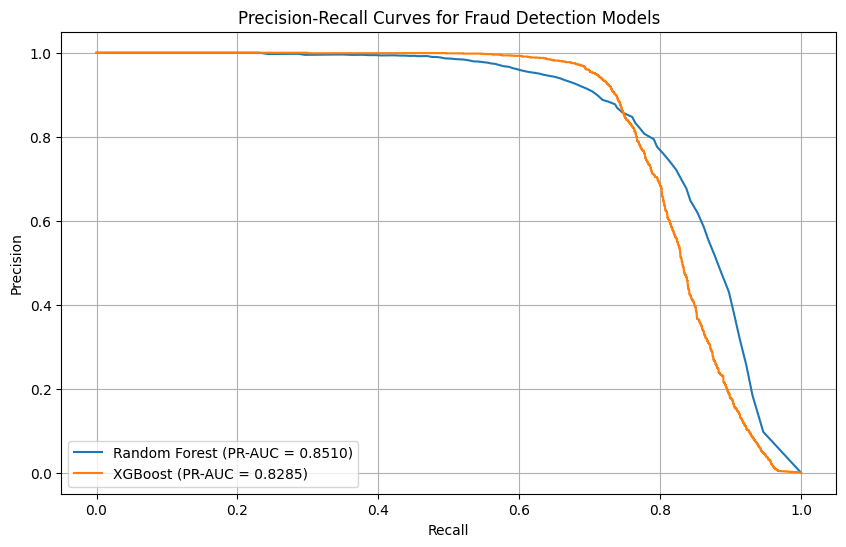

In [13]:
models = {
    'Random Forest': RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train == 0])/len(y_train[y_train]==1), random_state=42, eval_metric='auc')
}

results = {}

for name, model in models.items():
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc
    }

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")


plt.figure(figsize=(10,6))
for name in results:
    precision, recall, _ = precision_recall_curve(y_test, results[name]['y_pred_proba'])
    plt.plot(recall, precision, label=f'{name} (PR-AUC = {results[name]["pr_auc"]:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Fraud Detection Models')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


- In our scenario, detecting fraud cases is both crucial and costly, making recall the key metric to prioritize.
- XGBoost achieves a 70% recall rate for fraud (capturing 70 out of every 100 fraud transactions), outperforming Random Forest

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential(
    [
        Dense(256, activation='relu', input_shape=(X_train_final.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)

class_weight = {0: 1.0, 1:200.0}

model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall()]
)

model.summary()

c:\Users\rajku\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,385 (189.00 KB)

 Trainable params: 48,385 (189.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_recall',
    mode = 'max',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_final, y_train,
    validation_data=(X_test_final, y_test),
    epochs=20,
    batch_size=1024,
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
6965/6965 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.4415 - recall_3: 0.5961 - val_loss: 0.1598 - val_recall_3: 0.9089
Epoch 2/20


c:\Users\rajku\anaconda3\envs\myenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: loss,recall_3,val_loss,val_recall_3
  current = self.get_monitor_value(logs)


6965/6965 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.2925 - recall_3: 0.8166 - val_loss: 0.1002 - val_recall_3: 0.7869
Epoch 3/20
6965/6965 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.2756 - recall_3: 0.8086 - val_loss: 0.0975 - val_recall_3: 0.7967
Epoch 4/20
6965/6965 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.2776 - recall_3: 0.7995 - val_loss: 0.0899 - val_recall_3: 0.8226
Epoch 5/20
6965/6965 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.2692 - recall_3: 0.8032 - val_loss: 0.1032 - val_recall_3: 0.7618
Epoch 6/20
6965/6965 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.2701 - recall_3: 0.7922 - val_loss: 0.0845 - val_recall_3: 0.8170
Epoch 7/20
6965/6965 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.2682 - recall_3: 0.7985 - val_loss: 0.0642 - val_recall_3: 0.7059
Epoch 8/20
6965/6965 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.2670 - recall_3: 0.7900 - val_loss: 0.0626 - val_recall_3: 0.7206
Epoch 9/20
6965/6965 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.2650 - recall_3: 0.7902 - val

In [ ]:
y_pred_proba = model.predict(X_test_final, batch_size=1024)
y_pred = (y_pred_proba > 0.5).astype(int)

print("Deep Learning Results (Threshold 0.5):")
print(classification_report(y_test, y_pred))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
print(f"PR-AUC: {auc(recall, precision):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

y_pred_adjusted = (y_pred_proba > 0.45).astype(int)
print("Adjusted Threshold (0.45):")
print(classification_report(y_test, y_pred_adjusted))

1742/1742 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Deep Learning Results (Threshold 0.5):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1780327
           1       0.03      0.86      0.05      2666

    accuracy                           0.95   1782993
   macro avg       0.51      0.91      0.51   1782993
weighted avg       1.00      0.95      0.97   1782993

PR-AUC: 0.2778
ROC AUC: 0.9633
Adjusted Threshold (0.4):
              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1780327
           1       0.02      0.92      0.03      2666

    accuracy                           0.92   1782993
   macro avg       0.51      0.92      0.49   1782993
weighted avg       1.00      0.92      0.95   1782993



In [29]:
with open("deep_learning_model.pkl", "wb") as f:
    pickle.dump(model, f)